In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import numba as nb

In [2]:
# 参数定义
r_mean = 1.0  # 平均增长率
S = 40
D = 1e-6  # 迁移率
A_mean_range = [0.75, 1.25]  # 平均抑制系数范围
ystep = 21  # A_mean 的步数
pstep = 14  # A_mean 的步数


T_real = 1000  # 总进化时间
step = 0.05  # 时间间隔
T = int(np.ceil(T_real / step))  # 循环次数
num_sim = 200  # 系综平均次数
period = 200  # 用于计算丰富度的持续时间
abundance_threshold = 1e-3  # 物种生存的丰度阈值

# 初始化记录矩阵
fluc_record = np.zeros((pstep , ystep, num_sim))
diversity_record = np.zeros((pstep , ystep, num_sim))
livings_record = np.zeros((pstep , ystep, num_sim, S))
matrix_record = np.zeros((pstep , ystep, num_sim, S,S))
AA_record = np.zeros((pstep , ystep, num_sim,S,S))


fluc_mean = np.zeros((pstep , ystep))
div_mean = np.zeros((pstep , ystep))

A_mean = np.linspace(A_mean_range[0], A_mean_range[1], ystep)
print(A_mean)
ps = np.zeros(pstep)
for i in range(pstep-1):
    ps[i] = 1-0.75*np.power(0.65,i)
ps[pstep-1]=1

[0.75  0.775 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.    1.025
 1.05  1.075 1.1   1.125 1.15  1.175 1.2   1.225 1.25 ]


In [3]:
@jit(nopython=True)
def LV_compute( AA,A_m):

    N_mean = 0.5
    NN = np.zeros((T, S))
    r = np.ones(S)
    
    N0 = np.ones(S)*N_mean
    NN[0] = N0
    Migra = np.ones(S) * D
    
    for i in range(1, T):
        
        k1 = r * NN[i-1] * (1- np.dot(AA, NN[i-1]))* step
        k2 = r * (NN[i-1]+k1/2) * (1- np.dot(AA, NN[i-1]+k1/2))*step
        k3 = r * (NN[i-1]+k2/2) * (1- np.dot(AA, NN[i-1]+k2/2))*step
        k4 = r * (NN[i-1]+k3) * (1- np.dot(AA, NN[i-1]+k3))*step
        #NN[i] = NN[i-1] + r * NN[i-1] * (1- np.dot(AA, NN[i-1])) * step
        NN[i] = NN[i-1]+ (k1+2*k2+2*k3+k4)/6
        NN[i] += Migra  # 添加迁移
        
    return NN

In [4]:
@jit(nopython=True)
def axis_of_cols(matrix, num_cols):
    maxc = np.zeros(num_cols)
    livings=np.zeros(num_cols)
    flucc= np.zeros(num_cols)
    matrix_2 = matrix.T
    richness =0
    
    for i in range(num_cols):       
        maxc[i] =  np.max(matrix_2[i])
        if maxc[i]> abundance_threshold:
            livings[i] = 1
            richness+=1
            mean_v = np.mean(matrix_2[i])
            if mean_v!=0 and not np.isnan(np.std(matrix_2[i]) /mean_v):
                flucc[i] = np.std(matrix_2[i]) /mean_v

    return  richness, flucc, livings

In [5]:
def MatrixGen(p, A, num_modules = 4):
    intra_prob = p
    inter_prob = 1/3 -p/3
    nodes_per_module = [S // num_modules] * num_modules
    for i in range(S % num_modules):
        nodes_per_module[i] += 1

    module_node_list = []
    start = 0
    for size in nodes_per_module:
        module_node_list.append(list(range(start, start + size)))
        start += size

    # Initialize adjacency matrix
    adj_matrix = np.zeros((S, S))
    AA = np.zeros((S,S))
    # Generate edges
    for i in range(S):
        for j in range(i + 1, S):
            # Determine if nodes i and j are in the same module
            same_module = any(i in module and j in module for module in module_node_list)
            if same_module:  # Same module
                if np.random.rand() < intra_prob:
                    adj_matrix[i, j] = adj_matrix[j, i] = 1
                    AA[i,j]          = AA[j,i]          = np.random.randn()*A/36+A
                    if np.random.rand() < 0.5:
                        adj_matrix[i,j] = -1
                        AA[i,j]         = -1*AA[j,i]
            else:  # Different modules
                if np.random.rand() < inter_prob:
                    adj_matrix[i, j] = adj_matrix[j, i] = 1
                    AA[i,j]          = AA[j,i]          = np.random.randn()*A/36+A
                    if np.random.rand() < 0.5:
                        adj_matrix[i,j] = -1
                        AA[i,j]         = -1*AA[j,i]
    

    #AA = adj_matrix*A
    adj_matrix = adj_matrix+ np.eye(S)
    AA=AA+np.eye(S)
    
    
    return adj_matrix, AA

In [6]:
for pp in range(pstep):
    print("p=",ps[pp])
    for yy in range(ystep):
        rich_tot=0
        for hh in range(num_sim):
            # 调用 LV_compute 函数来计算组成
            adjacency_matrix, AA = MatrixGen(ps[pp], A_mean[yy])
            composition = LV_compute( AA, A_mean[yy] )
            richness,fluc_CV, livings = axis_of_cols(composition[T - period:T], S)
            if richness != np.sum(livings):
                print('wrong')
            diversity_record[pp , yy, hh] = richness / S
            livings_record[pp,yy,hh] = livings
            fluc_record[pp, yy, hh] = np.sum(fluc_CV)/richness
            matrix_record[pp,yy,hh] = adjacency_matrix
            AA_record[pp,yy,hh] = AA
            
        div_mean[pp,yy] = np.mean(diversity_record[pp,yy])
        fluc_mean[pp,yy]= np.sum(fluc_record[pp,yy]*diversity_record[pp,yy])/np.sum(diversity_record[pp,yy])

p= 0.25
p= 0.5125
p= 0.683125
p= 0.79403125
p= 0.8661203125
p= 0.912978203125
p= 0.94343583203125
p= 0.9632332908203125
p= 0.9761016390332031
p= 0.984466065371582
p= 0.9899029424915283
p= 0.9934369126194934
p= 0.9957339932026708
p= 1.0


In [7]:
fluc_mean_2 = np.zeros((pstep , ystep))
for pp in range(pstep):
    print("p=",ps[pp])
    for yy in range(ystep):
        rich_tot=0
        fluc_mean_2[pp,yy] = np.mean(fluc_record[pp,yy])

p= 0.25
p= 0.5125
p= 0.683125
p= 0.79403125
p= 0.8661203125
p= 0.912978203125
p= 0.94343583203125
p= 0.9632332908203125
p= 0.9761016390332031
p= 0.984466065371582
p= 0.9899029424915283
p= 0.9934369126194934
p= 0.9957339932026708
p= 1.0


In [8]:
def plot_3d_matrix(matrix):
    rows, cols = matrix.shape

    # 创建 X 和 Y 坐标
    
    #X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
    X, Y = np.meshgrid(ps, A_mean)

    # 绘制三维图
    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 使用矩阵值作为 Z 坐标
    Z = matrix

    # 绘制曲面
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')

    # 添加颜色条
    fig.colorbar(surf, shrink=0.5, aspect=10)

    # 设置标题和标签
    ax.set_title('3D Matrix Visualization')
    A_mean_p = A_mean
    ps_p = ps
    A_mean_p= np.around(A_mean_p,3)
    ps_p = np.around(ps_p,3)
    ax.set_yticks(A_mean_p[::5])
    ax.set_xticks(ps_p[:-10])
    ax.set_xlabel('p')
    ax.set_ylabel('Interaction')
    ax.set_zlabel('Matrix Value')

    plt.show()

In [9]:
def plot_3d_matrix_ori(matrix):
    rows, cols = matrix.shape

    # 创建 X 和 Y 坐标
    
    X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
    #X, Y = np.meshgrid(ps, A_mean)

    # 绘制三维图
    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 使用矩阵值作为 Z 坐标
    Z = matrix

    # 绘制曲面
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')

    # 添加颜色条
    fig.colorbar(surf, shrink=0.5, aspect=10)
    A_mean_p = A_mean
    ps_p = ps
    A_mean_p = np.around(A_mean_p,3)
    ps_p = np.around(ps_p,3)
    # 设置标题和标签
    ax.set_title('3D Matrix Visualization')
    ax.set_yticks(np.arange(0,ystep,5),A_mean_p[::5])
    ax.set_xticks(np.arange(0,pstep,5),ps_p[::5])
    ax.set_xlabel('p')
    ax.set_ylabel('Interaction')
    ax.set_zlabel('Matrix Value')

    plt.show()

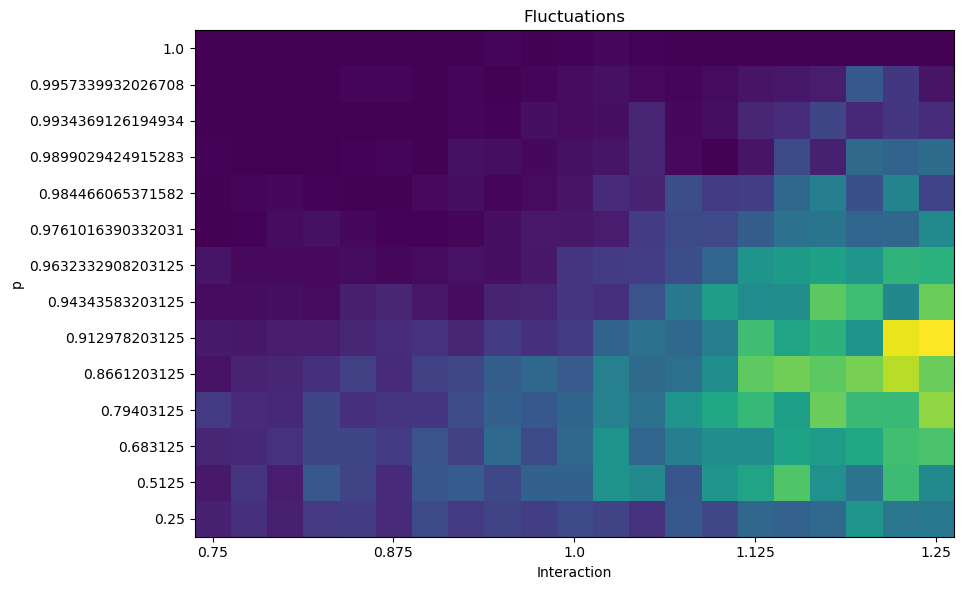

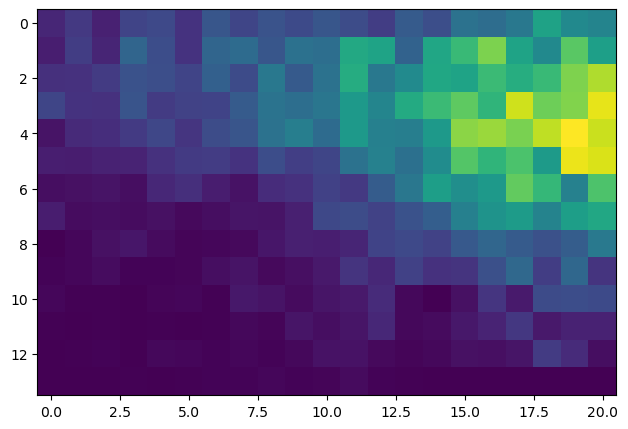

In [10]:
plt.figure(figsize=(30, 6))
plt.imshow(fluc_mean,origin='lower')
plt.xticks(np.arange(0,ystep,5),A_mean[::5])
plt.yticks(np.arange(0,pstep,1),ps)
plt.xlabel("Interaction")  # 设置横轴标签
plt.ylabel("p")  # 设置纵轴标签
plt.title("Fluctuations")   # 设置标题（可选）
plt.tight_layout()
plt.show()

plt.imshow(fluc_mean_2)
plt.tight_layout()
plt.show()

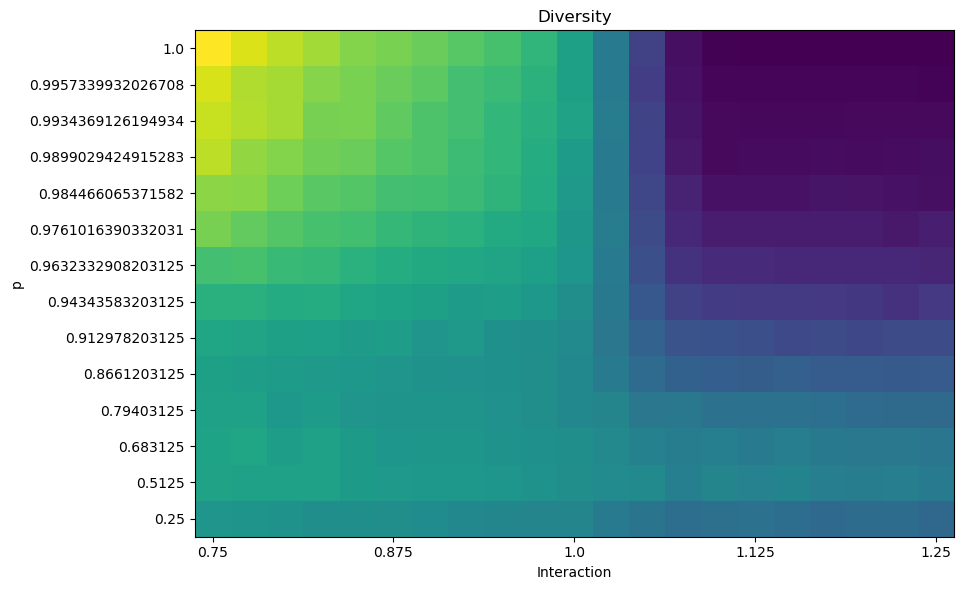

In [11]:
plt.figure(figsize=(30, 6))
plt.imshow(div_mean, origin='lower')
plt.xticks(np.arange(0,ystep,5),A_mean[::5])
plt.yticks(np.arange(0,pstep,1),ps)
plt.xlabel("Interaction")  # 设置横轴标签
plt.ylabel("p")  # 设置纵轴标签
plt.title("Diversity")   # 设置标题（可选）
plt.tight_layout()
plt.show()

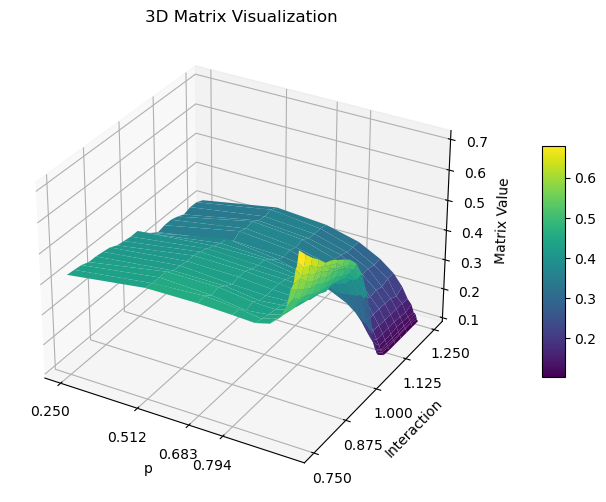

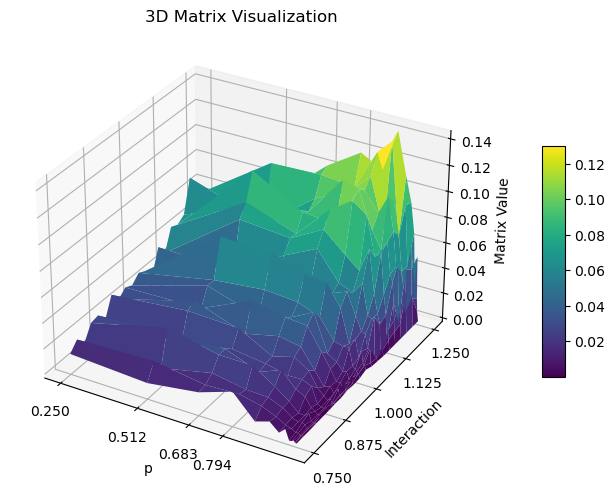

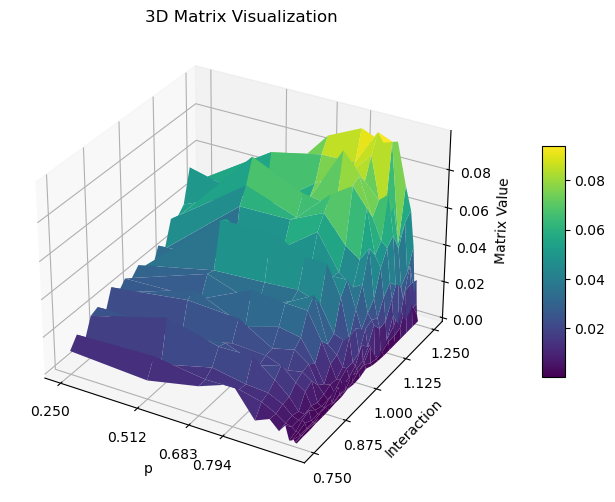

In [12]:
plot_3d_matrix(div_mean.T)
plot_3d_matrix(fluc_mean.T)
plot_3d_matrix(fluc_mean_2.T)

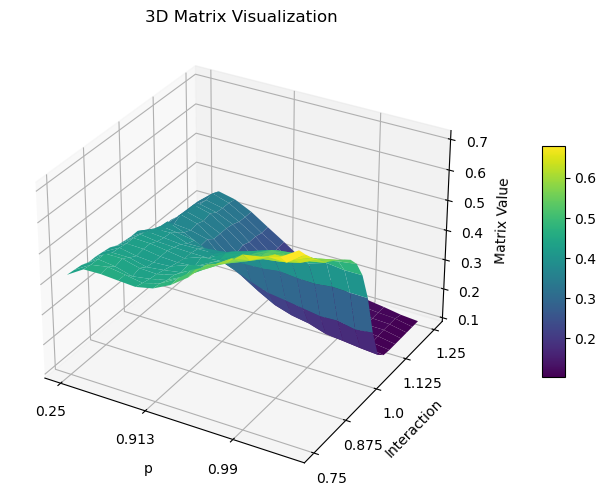

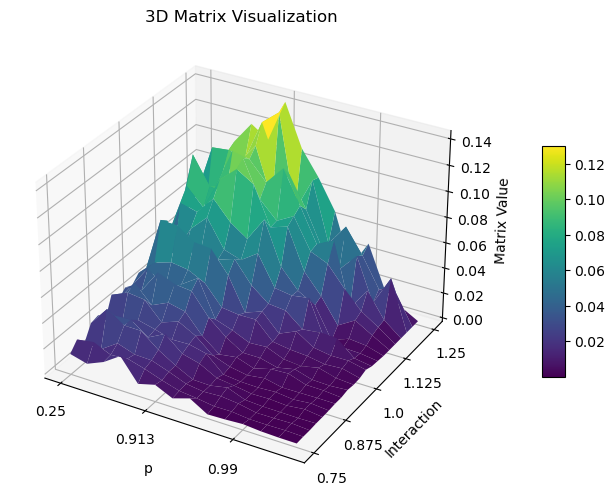

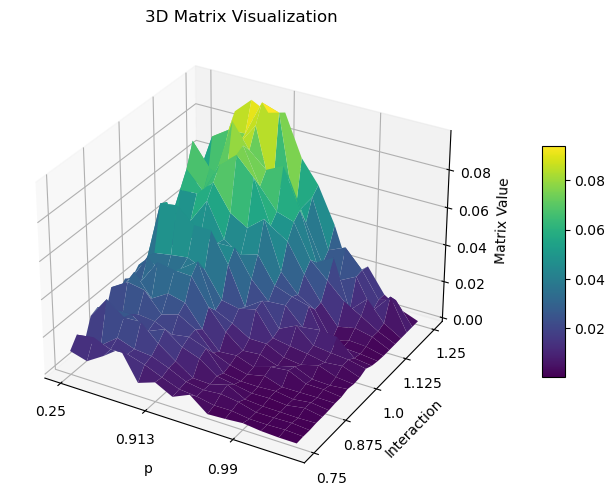

In [13]:
plot_3d_matrix_ori(div_mean.T)
plot_3d_matrix_ori(fluc_mean.T)
plot_3d_matrix_ori(fluc_mean_2.T)

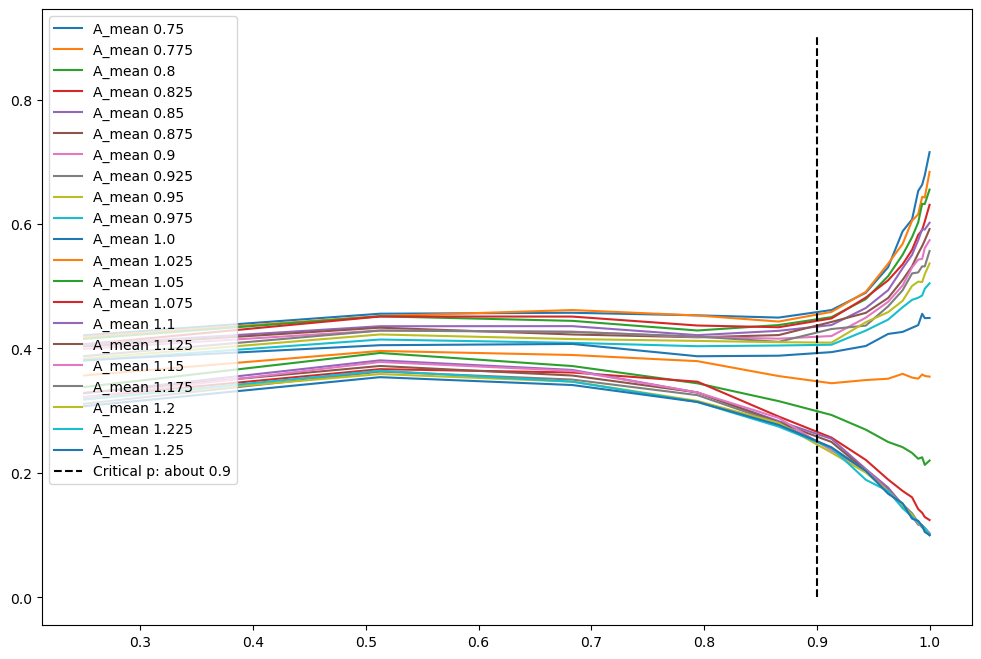

In [14]:
plt.figure(figsize=(12, 8))
for i in range(ystep):
    plt.plot(ps[:],div_mean[:,i],label=f"A_mean {A_mean[i]}")

xxx= np.ones(10)*0.9
yyy= np.arange(10)*0.1
plt.plot(xxx,yyy,linestyle='--', color = 'black',label=f"Critical p: about {0.9}")
plt.legend(loc='upper left')
plt.show()

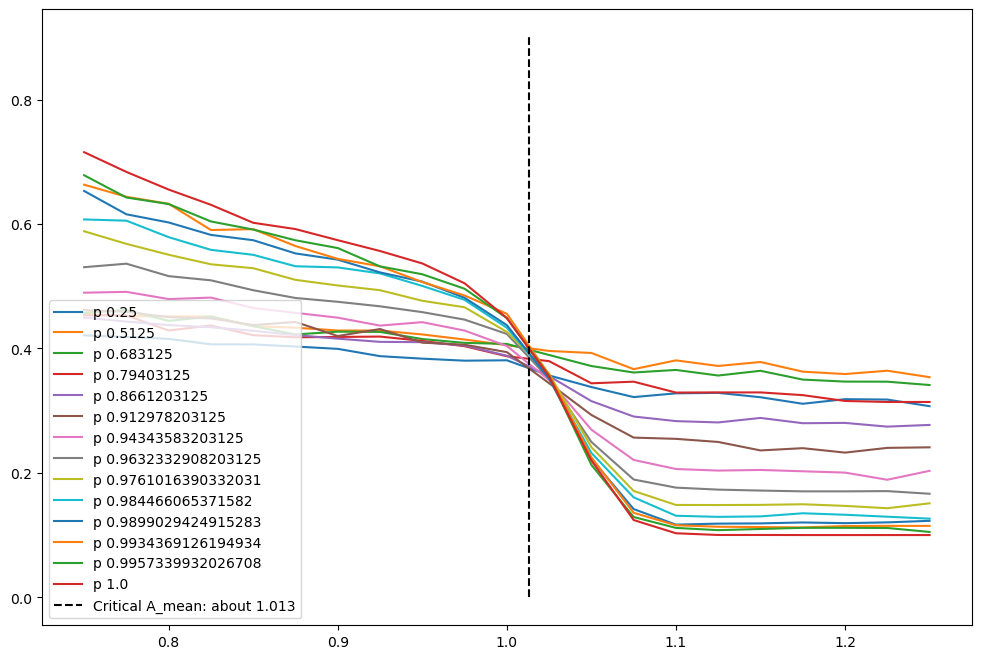

In [15]:
plt.figure(figsize=(12, 8))
for i in range(pstep):
    plt.plot(A_mean,div_mean[i,:],label=f"p {ps[i]}")
xxx= np.ones(10)*1.013
yyy= np.arange(10)*0.1
plt.plot(xxx,yyy,linestyle='--', color = 'black',label=f"Critical A_mean: about {1.013}")

plt.legend(loc='lower left')
plt.show()

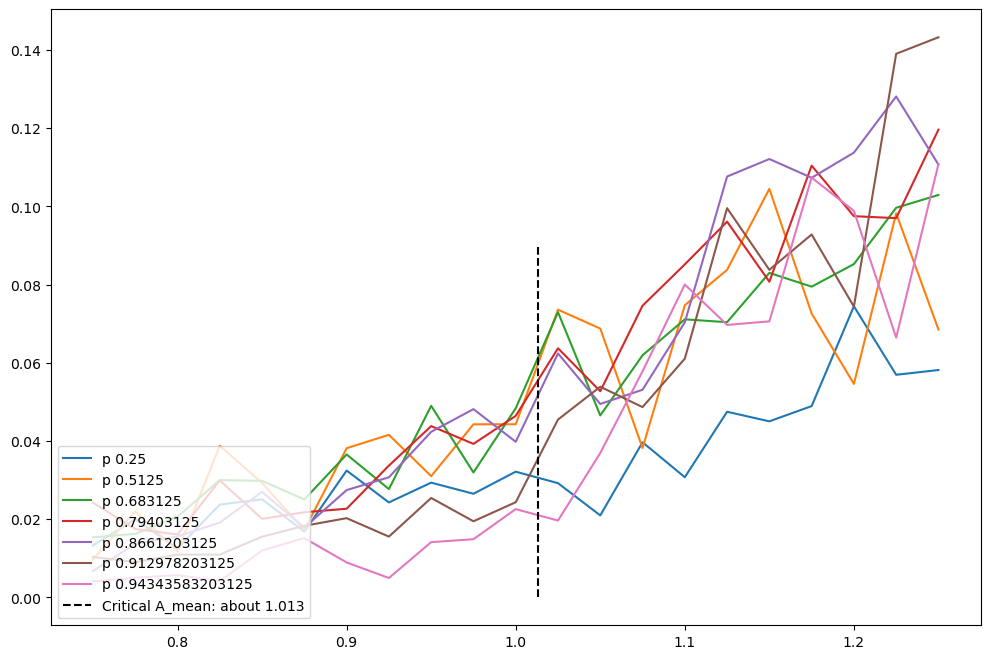

In [16]:
plt.figure(figsize=(12, 8))
for i in range(7):
    plt.plot(A_mean,fluc_mean[i,:],label=f"p {ps[i]}")
xxx= np.ones(10)*1.013
yyy= np.arange(10)*0.01
plt.plot(xxx,yyy,linestyle='--', color = 'black',label=f"Critical A_mean: about {1.013}")

plt.legend(loc='lower left')
plt.show()

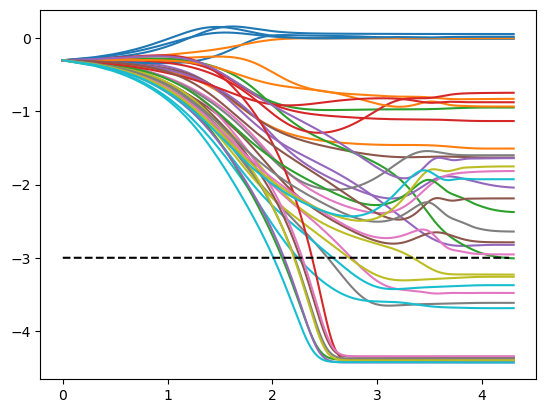

In [17]:
adjacency_matrix, AA = MatrixGen(0.98, 0.75)
composition = LV_compute( AA, 4 )
x_zhou = np.arange(T)
y_zhou = -3*np.ones(T)
for i in range(S):
    plt.plot(np.log(x_zhou+1)*0.4343,np.log(composition.T[i])*0.4343)

plt.plot(np.log(x_zhou+1)*0.43,y_zhou,linestyle='--', color = 'black')

In [18]:
np.save('diversity_record_222.npy', diversity_record)

np.save('fluc_record_222.npy', fluc_record)
np.save('div_mean_222.npy',div_mean)
np.save('fluc_mean_222.npy',fluc_mean)
np.save('AA_record_222.npy', AA_record)
np.save('livings_record_222.npy', livings_record)
np.save('matrix_record_222.npy', matrix_record)
np.save('A_mean_222.npy',A_mean)
np.save('ps_222.npy',ps)

In [21]:
print(livings_record[1,1,1])
print(np.sum(livings_record[1,1,1])/40)
print(diversity_record[1,1,1])


[1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
0.4
0.4
